In [67]:
# 1. 导入系统库函数和其它库

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SVM import *

In [13]:
# 2. 导入数据库，把feather形式转换成csv可读形式文件

!pip install feather-format
import feather

read_feather = feather.read_dataframe("stk_daily.feather")
transform_daily = read_feather.to_csv("stk_daily.csv")
daily_data = pd.read_csv('stk_daily.csv')

In [14]:
# 3. 处理原始表格并计算各项指标
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data.set_index('date', inplace=True)
daily_data

,Unnamed: 0,stk_id,open,high,low,close,volume,amount,cumadj
date,,,,,,,,,
2020-01-02,0,000001.SZ,16.65,16.95,16.55,16.87,153023000.0,2.571200e+09,98.098600
2020-01-03,1,000001.SZ,16.94,17.31,16.92,17.18,111619000.0,1.914500e+09,98.098600
2020-01-06,2,000001.SZ,17.01,17.34,16.91,17.07,86208400.0,1.477930e+09,98.098600
2020-01-07,3,000001.SZ,17.13,17.28,16.95,17.15,72860800.0,1.247050e+09,98.098600
2020-01-08,4,000001.SZ,17.00,17.05,16.63,16.66,84782400.0,1.423610e+09,98.098600
...,...,...,...,...,...,...,...,...,...
2022-12-26,3228802,873527.BJ,8.03,8.18,8.00,8.06,86600.0,6.976570e+05,0.773424
2022-12-27,3228803,873527.BJ,8.01,8.16,8.00,8.05,61400.0,4.934280e+05,0.773429
2022-12-28,3228804,873527.BJ,8.04,8.09,8.03,8.06,43900.0,3.534580e+05,0.773424


In [20]:
def calculate_returns(df):
    df['returns'] = df['close'].pct_change() * df['cumadj']
    return df

daily_data = calculate_returns(daily_data)
daily_data

,Unnamed: 0,stk_id,open,high,low,close,volume,amount,cumadj,open_close_change,high_low_change,returns
date,,,,,,,,,,,,
2020-01-02,0,000001.SZ,16.65,16.95,16.55,16.87,153023000.0,2.571200e+09,98.098600,NaN,NaN,NaN
2020-01-03,1,000001.SZ,16.94,17.31,16.92,17.18,111619000.0,1.914500e+09,98.098600,0.004149,0.023118,1.802642
2020-01-06,2,000001.SZ,17.01,17.34,16.91,17.07,86208400.0,1.477930e+09,98.098600,-0.009895,0.025029,-0.628105
2020-01-07,3,000001.SZ,17.13,17.28,16.95,17.15,72860800.0,1.247050e+09,98.098600,0.003515,0.019332,0.459747
2020-01-08,4,000001.SZ,17.00,17.05,16.63,16.66,84782400.0,1.423610e+09,98.098600,-0.008746,0.024490,-2.802817
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3228802,873527.BJ,8.03,8.18,8.00,8.06,86600.0,6.976570e+05,0.773424,-0.002484,0.022360,0.000961
2022-12-27,3228803,873527.BJ,8.01,8.16,8.00,8.05,61400.0,4.934280e+05,0.773429,-0.006203,0.019851,-0.000960
2022-12-28,3228804,873527.BJ,8.04,8.09,8.03,8.06,43900.0,3.534580e+05,0.773424,-0.001242,0.007453,0.000961


In [15]:
def intraday_reversal_strategy(daily_data, entry_open_close_threshold=0.005, entry_high_low_threshold=0.01):
    signals = pd.DataFrame(index=daily_data.index)
    signals['signal'] = 0.0

    # 计算价格变化
    daily_data['open_close_change'] = (daily_data['open'] - daily_data['close'].shift(1)) / daily_data['close'].shift(1)
    daily_data['high_low_change'] = (daily_data['high'] - daily_data['low']) / daily_data['close'].shift(1)

    # 生成交易信号
    signals['signal'] = np.where(daily_data['open_close_change'] > entry_open_close_threshold, -1.0, 0.0)  # 卖出信号
    signals['signal'] = np.where(daily_data['open_close_change'] < -entry_open_close_threshold, 1.0, signals['signal'])  # 买入信号
    signals['signal'] = np.where(daily_data['high_low_change'] > entry_high_low_threshold, -1.0, signals['signal'])  # 卖出信号
    signals['signal'] = np.where(daily_data['high_low_change'] < -entry_high_low_threshold, 1.0, signals['signal'])  # 买入信号

    return signals

In [34]:
def calculate_nav(df):
    df['NAV'] = (1 + df['returns']).cumprod()
    df['NAV'] = df['NAV'].shift(1).fillna(1)
    return df

daily_data = calculate_nav(daily_data)
daily_data

,Unnamed: 0,stk_id,open,high,low,close,volume,amount,cumadj,open_close_change,...,returns,strategy,strategy_returns,cumulative_strategy_returns,excess_returns,annual_returns_strategy,annual_volatility,sharpe_ratio,max_drawdown,NAV
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0,000001.SZ,16.65,16.95,16.55,16.87,153023000.0,2.571200e+09,98.098600,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,119.599679,-0.008361,-51568.879018,1.000000
2020-01-03,1,000001.SZ,16.94,17.31,16.92,17.18,111619000.0,1.914500e+09,98.098600,0.004149,...,1.802642,0.0,0.000000,1.000000,0.000000e+00,-1.0,119.599679,-0.008361,-51568.879018,1.000000
2020-01-06,2,000001.SZ,17.01,17.34,16.91,17.07,86208400.0,1.477930e+09,98.098600,-0.009895,...,-0.628105,-1.0,0.628105,1.628105,0.000000e+00,-1.0,119.599679,-0.008361,-51568.879018,2.802642
2020-01-07,3,000001.SZ,17.13,17.28,16.95,17.15,72860800.0,1.247050e+09,98.098600,0.003515,...,0.459747,-1.0,-0.459747,0.879588,-7.485171e-01,-1.0,119.599679,-0.008361,-51568.879018,1.042288
2020-01-08,4,000001.SZ,17.00,17.05,16.63,16.66,84782400.0,1.423610e+09,98.098600,-0.008746,...,-2.802817,-1.0,2.802817,3.344912,0.000000e+00,-1.0,119.599679,-0.008361,-51568.879018,1.521477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3228802,873527.BJ,8.03,8.18,8.00,8.06,86600.0,6.976570e+05,0.773424,-0.002484,...,0.000961,-1.0,-0.000961,-0.000000,-1.232767e+193,-1.0,119.599679,-0.008361,-51568.879018,0.000000
2022-12-27,3228803,873527.BJ,8.01,8.16,8.00,8.05,61400.0,4.934280e+05,0.773429,-0.006203,...,-0.000960,-1.0,0.000960,-0.000000,-1.232767e+193,-1.0,119.599679,-0.008361,-51568.879018,0.000000
2022-12-28,3228804,873527.BJ,8.04,8.09,8.03,8.06,43900.0,3.534580e+05,0.773424,-0.001242,...,0.000961,-1.0,-0.000961,-0.000000,-1.232767e+193,-1.0,119.599679,-0.008361,-51568.879018,0.000000


In [31]:
# 计算策略表现指标
def calculate_performance_metrics(daily_data, signals):
    daily_data['strategy'] = signals['signal'].shift(1)

    # 计算净值曲线
    daily_data['strategy_returns'] = daily_data['strategy'] * daily_data['returns']
    daily_data['cumulative_strategy_returns'] = (1 + daily_data['strategy_returns']).cumprod()

    # 计算超额收益
    excess_returns = daily_data['cumulative_strategy_returns'] - daily_data['cumulative_strategy_returns'].cummax()
    daily_data['excess_returns'] = excess_returns

    # 计算年化收益率
    annual_returns_strategy = (daily_data['cumulative_strategy_returns'].iloc[-1])**(252/len(daily_data.index)) - 1
    daily_data['annual_returns_strategy'] = annual_returns_strategy

    # 计算年化波动
    annual_volatility = daily_data['strategy_returns'].std() * np.sqrt(252)
    daily_data['annual_volatility'] = annual_volatility

    # 计算夏普比率
    sharpe_ratio = annual_returns_strategy / annual_volatility
    daily_data['sharpe_ratio'] = sharpe_ratio

    # 计算最大回撤
    max_drawdown = (daily_data['cumulative_strategy_returns'] / daily_data['cumulative_strategy_returns'].cummax() - 1).min()
    daily_data['max_drawdown'] = max_drawdown

    return daily_data

daily_data

,Unnamed: 0,stk_id,open,high,low,close,volume,amount,cumadj,open_close_change,high_low_change,returns,strategy,strategy_returns,cumulative_strategy_returns,excess_returns,annual_returns_strategy
date,,,,,,,,,,,,,,,,,
2020-01-02,0,000001.SZ,16.65,16.95,16.55,16.87,153023000.0,2.571200e+09,98.098600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2020-01-03,1,000001.SZ,16.94,17.31,16.92,17.18,111619000.0,1.914500e+09,98.098600,0.004149,0.023118,1.802642,0.0,0.000000,1.000000,0.000000e+00,-1.0
2020-01-06,2,000001.SZ,17.01,17.34,16.91,17.07,86208400.0,1.477930e+09,98.098600,-0.009895,0.025029,-0.628105,-1.0,0.628105,1.628105,0.000000e+00,-1.0
2020-01-07,3,000001.SZ,17.13,17.28,16.95,17.15,72860800.0,1.247050e+09,98.098600,0.003515,0.019332,0.459747,-1.0,-0.459747,0.879588,-7.485171e-01,-1.0
2020-01-08,4,000001.SZ,17.00,17.05,16.63,16.66,84782400.0,1.423610e+09,98.098600,-0.008746,0.024490,-2.802817,-1.0,2.802817,3.344912,0.000000e+00,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3228802,873527.BJ,8.03,8.18,8.00,8.06,86600.0,6.976570e+05,0.773424,-0.002484,0.022360,0.000961,-1.0,-0.000961,-0.000000,-1.232767e+193,-1.0
2022-12-27,3228803,873527.BJ,8.01,8.16,8.00,8.05,61400.0,4.934280e+05,0.773429,-0.006203,0.019851,-0.000960,-1.0,0.000960,-0.000000,-1.232767e+193,-1.0
2022-12-28,3228804,873527.BJ,8.04,8.09,8.03,8.06,43900.0,3.534580e+05,0.773424,-0.001242,0.007453,0.000961,-1.0,-0.000961,-0.000000,-1.232767e+193,-1.0


In [32]:
# 运行策略
signals = intraday_reversal_strategy(daily_data)
data_with_metrics = calculate_performance_metrics(daily_data, signals)
data_with_metrics

,Unnamed: 0,stk_id,open,high,low,close,volume,amount,cumadj,open_close_change,high_low_change,returns,strategy,strategy_returns,cumulative_strategy_returns,excess_returns,annual_returns_strategy,annual_volatility,sharpe_ratio,max_drawdown
date,,,,,,,,,,,,,,,,,,,,
2020-01-02,0,000001.SZ,16.65,16.95,16.55,16.87,153023000.0,2.571200e+09,98.098600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,119.599679,-0.008361,-51568.879018
2020-01-03,1,000001.SZ,16.94,17.31,16.92,17.18,111619000.0,1.914500e+09,98.098600,0.004149,0.023118,1.802642,0.0,0.000000,1.000000,0.000000e+00,-1.0,119.599679,-0.008361,-51568.879018
2020-01-06,2,000001.SZ,17.01,17.34,16.91,17.07,86208400.0,1.477930e+09,98.098600,-0.009895,0.025029,-0.628105,-1.0,0.628105,1.628105,0.000000e+00,-1.0,119.599679,-0.008361,-51568.879018
2020-01-07,3,000001.SZ,17.13,17.28,16.95,17.15,72860800.0,1.247050e+09,98.098600,0.003515,0.019332,0.459747,-1.0,-0.459747,0.879588,-7.485171e-01,-1.0,119.599679,-0.008361,-51568.879018
2020-01-08,4,000001.SZ,17.00,17.05,16.63,16.66,84782400.0,1.423610e+09,98.098600,-0.008746,0.024490,-2.802817,-1.0,2.802817,3.344912,0.000000e+00,-1.0,119.599679,-0.008361,-51568.879018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,3228802,873527.BJ,8.03,8.18,8.00,8.06,86600.0,6.976570e+05,0.773424,-0.002484,0.022360,0.000961,-1.0,-0.000961,-0.000000,-1.232767e+193,-1.0,119.599679,-0.008361,-51568.879018
2022-12-27,3228803,873527.BJ,8.01,8.16,8.00,8.05,61400.0,4.934280e+05,0.773429,-0.006203,0.019851,-0.000960,-1.0,0.000960,-0.000000,-1.232767e+193,-1.0,119.599679,-0.008361,-51568.879018
2022-12-28,3228804,873527.BJ,8.04,8.09,8.03,8.06,43900.0,3.534580e+05,0.773424,-0.001242,0.007453,0.000961,-1.0,-0.000961,-0.000000,-1.232767e+193,-1.0,119.599679,-0.008361,-51568.879018


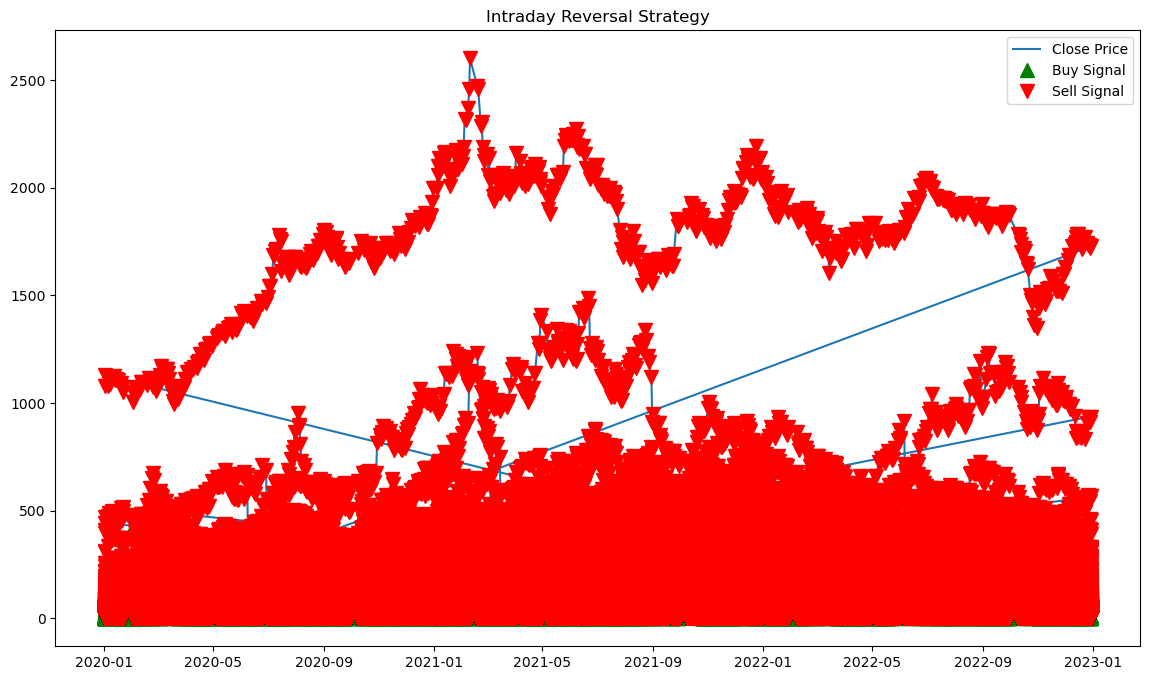

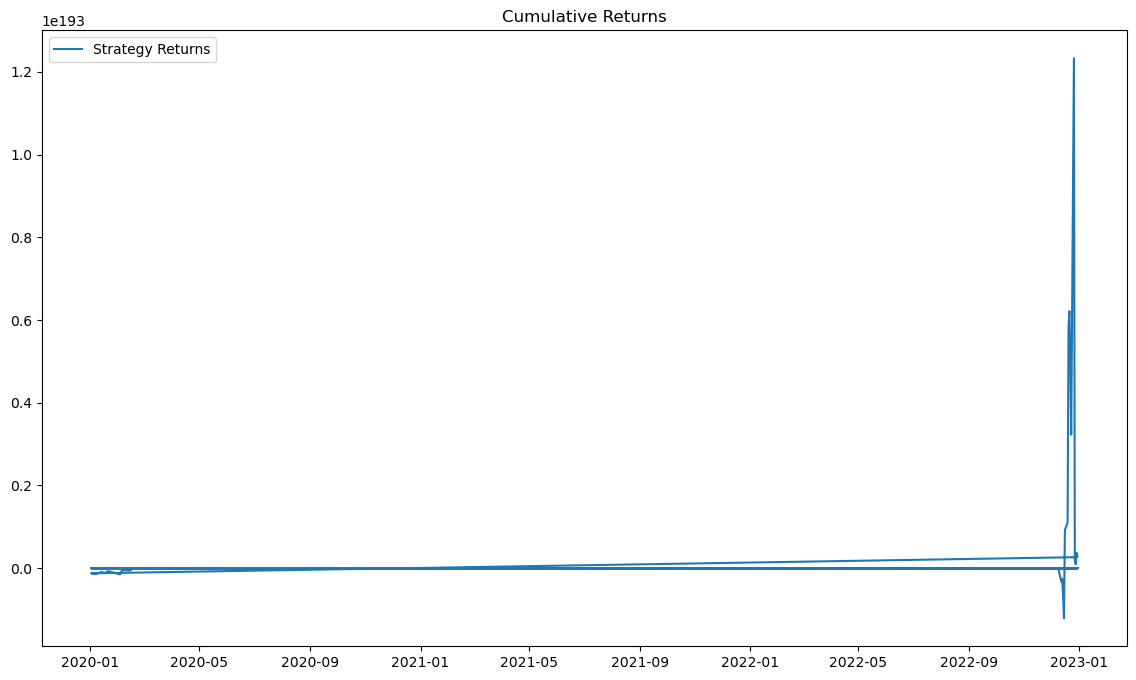

In [35]:
plt.figure(figsize=(14, 8))
plt.plot(daily_data.index, daily_data['close'], label='Close Price')
plt.plot(signals.loc[signals['signal'] == 1.0].index, daily_data['close'][signals['signal'] == 1.0], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(signals.loc[signals['signal'] == -1.0].index, daily_data['close'][signals['signal'] == -1.0], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('Intraday Reversal Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(data_with_metrics.index, data_with_metrics['cumulative_strategy_returns'], label='Strategy Returns')
plt.title('Cumulative Returns')
plt.legend()
plt.show()